In [2]:
import pandas as pd
import numpy as np

In [3]:
TY_label = pd.read_excel('../../data/TY_training_labels_v2.xlsx')
TY_data = pd.read_csv('../../data/TY_training_ULT.csv')

/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_83952/879553019.py:2: DtypeWarning: Columns (1449,1450,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488) have mixed types. Specify dtype option on import or set low_memory=False.
  TY_data = pd.read_csv('../../data/TY_training_ULT.csv')


# Drop non-test columns

In [4]:
# Function to drop columns (tests) in the raw data file which are NOT tests (i.e metadata like start time, lot number etc)
def test_only(datafile,labelfile):
    keys = list(labelfile['Name'])
    df = datafile[keys]
    return df

In [5]:
#Applying the functions to file 
TY_dropped = test_only(TY_data,TY_label)
#Checking the shape and how the data looks like
print(TY_dropped.shape)
print(TY_dropped.head())

(79783, 1402)
   temperature  Device_Test_Time  Part_Id  a_openXv_SIG_x_x_500uA__NFC_GPIO0  \
0        125.0           71734.0      1.0                          -0.544749   
1        125.0           71734.0      2.0                          -0.542050   
2        125.0           71734.0      3.0                          -0.540997   
3        125.0           71734.0      4.0                          -0.538849   
4        125.0           71734.0      5.0                          -0.536129   

   a_shortXv_SIG_x_x_500uA__NFC_GPIO0  a_openXv_SIG_x_x_500uA__NFC_GPIO1  \
0                           -0.544749                          -0.543823   
1                           -0.542050                          -0.543497   
2                           -0.540997                          -0.540728   
3                           -0.538849                          -0.538906   
4                           -0.536129                          -0.537837   

   a_shortXv_SIG_x_x_500uA__NFC_GPIO1  a_openXv_

# Drop unlabelled columns (without target variable)

In [6]:
#Function to find out non applicable rows (no distribution, not part of training data)
def non_applicable (df_label):
    null_rowsLabel = df_label[df_label['Distribution Type'].isnull()]
    null_rowsLabel = list(null_rowsLabel['Name'])
    return null_rowsLabel

In [7]:
#Applying the above function to set of data
TY_non_applicable = non_applicable(TY_label)
#Printing the tests (columns) to see which tests do not have a distribution (i.e not applicable)
print(TY_non_applicable)
print(len(TY_non_applicable))

[]
0


In [8]:
#Function to faciliate the dropping of the null rows in labels file
def drop_null_labels(label_df,not_applicable):
    df = label_df.drop(label_df[label_df.Name.isin(not_applicable)].index)
    return df

In [9]:
# Applying it to set of data
TY_label_final = drop_null_labels(TY_label,TY_non_applicable)
TY_label_final

,Name,Mean,Standard Deviation,Parameter Type,Distribution Type,Comments
0,temperature,125.000000,0.000000,NaN,functional,NaN
1,Device_Test_Time,52517.820212,1812.012713,PARAMETRIC,bimodal,NaN
2,Part_Id,2849.892872,1645.108043,PARAMETRIC,bimodal,NaN
3,a_openXv_SIG_x_x_500uA__NFC_GPIO0,-0.533726,0.013324,PARAMETRIC,outlier,NaN
4,a_shortXv_SIG_x_x_500uA__NFC_GPIO0,-0.533726,0.013324,PARAMETRIC,outlier,NaN
...,...,...,...,...,...,...
1397,f_nvm_programXxXPgmPatrepairinfo2M1YvhsYvhsYyY...,-0.974299,0.158303,PARAMETRIC,functional,NaN
1398,f_nvm_readifrXxXVfyPatrepairinfo2M1YvhsYvhsYyY...,-0.974299,0.158303,PARAMETRIC,functional,NaN
1399,f_nvm_XxXRdoutPatrepairinfo3M1YvhsYvhsYyYYy_1....,0.000000,0.000000,PARAMETRIC,functional,NaN
1400,f_nvm_readifrXxXVfyPatrepairinfo3M1YvhsYvhsYyY...,-0.413170,0.492482,PARAMETRIC,functional,NaN


# Filter columns down to test name and distribution 

In [10]:
TY_target = TY_label_final[['Name','Distribution Type']]
TY_target

,Name,Distribution Type
0,temperature,functional
1,Device_Test_Time,bimodal
2,Part_Id,bimodal
3,a_openXv_SIG_x_x_500uA__NFC_GPIO0,outlier
4,a_shortXv_SIG_x_x_500uA__NFC_GPIO0,outlier
...,...,...
1397,f_nvm_programXxXPgmPatrepairinfo2M1YvhsYvhsYyY...,functional
1398,f_nvm_readifrXxXVfyPatrepairinfo2M1YvhsYvhsYyY...,functional
1399,f_nvm_XxXRdoutPatrepairinfo3M1YvhsYvhsYyYYy_1....,functional
1400,f_nvm_readifrXxXVfyPatrepairinfo3M1YvhsYvhsYyY...,functional


In [11]:
distribution_counts = TY_target['Distribution Type'].value_counts()
distribution_counts

Distribution Type
functional    1063
outlier         91
longtail        72
normal          69
discrete        54
bimodal         53
Name: count, dtype: int64

In [12]:
TY_transposed = TY_dropped.T.reset_index(inplace=False, drop=False)

TY_transposed.columns = ['Name'] + [i for i in range(1, len(TY_transposed.columns))]
TY_transposed

,Name,1,2,3,4,5,6,7,8,9,...,79774,79775,79776,79777,79778,79779,79780,79781,79782,79783
0,temperature,125.000000,125.00000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,...,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.00000
1,Device_Test_Time,71734.000000,71734.00000,71734.000000,71734.000000,71734.000000,71734.000000,71734.000000,71734.000000,71734.000000,...,50853.000000,50853.000000,50853.000000,50853.000000,50853.000000,50853.000000,50853.000000,50853.000000,50853.000000,50853.00000
2,Part_Id,1.000000,2.00000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,5689.000000,5690.000000,5691.000000,5692.000000,5693.000000,5694.000000,5695.000000,5696.000000,5697.000000,5698.00000
3,a_openXv_SIG_x_x_500uA__NFC_GPIO0,-0.544749,-0.54205,-0.540997,-0.538849,-0.536129,-0.535918,-0.534637,-0.534009,-0.544783,...,-0.535343,-0.535356,-0.536438,-0.536239,-0.541173,-0.541914,-0.539849,-0.537799,-0.537331,-0.53763
4,a_shortXv_SIG_x_x_500uA__NFC_GPIO0,-0.544749,-0.54205,-0.540997,-0.538849,-0.536129,-0.535918,-0.534637,-0.534009,-0.544783,...,-0.535343,-0.535356,-0.536438,-0.536239,-0.541173,-0.541914,-0.539849,-0.537799,-0.537331,-0.53763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397,f_nvm_programXxXPgmPatrepairinfo2M1YvhsYvhsYyY...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1398,f_nvm_readifrXxXVfyPatrepairinfo2M1YvhsYvhsYyY...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1399,f_nvm_XxXRdoutPatrepairinfo3M1YvhsYvhsYyYYy_1....,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1400,f_nvm_readifrXxXVfyPatrepairinfo3M1YvhsYvhsYyY...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
ty_merged = pd.merge(TY_target, TY_transposed, on='Name', how='inner')
df_ty = ty_merged.T

In [14]:
df_ty

,0,1,2,3,4,5,6,7,8,9,...,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401
Name,temperature,Device_Test_Time,Part_Id,a_openXv_SIG_x_x_500uA__NFC_GPIO0,a_shortXv_SIG_x_x_500uA__NFC_GPIO0,a_openXv_SIG_x_x_500uA__NFC_GPIO1,a_shortXv_SIG_x_x_500uA__NFC_GPIO1,a_openXv_SIG_x_x_500uA__NFC-GPIO2_AO,a_shortXv_SIG_x_x_500uA__NFC-GPIO2_AO,a_openXv_SIG_x_x_500uA__NFC_GPIO3_AO,...,f_nvm_readifrXxXVfyPatrepairinfo1M1YvhsYvhsYyY...,f_nvm_programXxXPgmPatrepairinfo1M1YvhsYvhsYyY...,f_nvm_readifrXxXVfyPatrepairinfo1M1YvhsYvhsYyY...,f_nvm_XxXRdoutPatrepairinfo2M1YvhsYvhsYyYYy_1....,f_nvm_readifrXxXVfyPatrepairinfo2M1YvhsYvhsYyY...,f_nvm_programXxXPgmPatrepairinfo2M1YvhsYvhsYyY...,f_nvm_readifrXxXVfyPatrepairinfo2M1YvhsYvhsYyY...,f_nvm_XxXRdoutPatrepairinfo3M1YvhsYvhsYyYYy_1....,f_nvm_readifrXxXVfyPatrepairinfo3M1YvhsYvhsYyY...,f_nvm_programXxXPgmPatrepairinfo3M1YvhsYvhsYyY...
Distribution Type,functional,bimodal,bimodal,outlier,outlier,outlier,outlier,outlier,outlier,outlier,...,functional,functional,functional,functional,functional,functional,functional,functional,functional,functional
1,125.0,71734.0,1.0,-0.544749,-0.544749,-0.543823,-0.543823,-0.421532,-0.421532,-0.422727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,125.0,71734.0,2.0,-0.54205,-0.54205,-0.543497,-0.543497,-0.417037,-0.417037,-0.417872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,125.0,71734.0,3.0,-0.540997,-0.540997,-0.540728,-0.540728,-0.41555,-0.41555,-0.416643,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79779,125.0,50853.0,5694.0,-0.541914,-0.541914,-0.541302,-0.541302,-0.419085,-0.419085,-0.418765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79780,125.0,50853.0,5695.0,-0.539849,-0.539849,-0.540376,-0.540376,-0.416837,-0.416837,-0.417859,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79781,125.0,50853.0,5696.0,-0.537799,-0.537799,-0.537329,-0.537329,-0.410395,-0.410395,-0.411985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79782,125.0,50853.0,5697.0,-0.537331,-0.537331,-0.538301,-0.538301,-0.412194,-0.412194,-0.410885,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
import pickle

data = df_ty

with open('ty_values_dataframe.pkl', 'wb') as file:
    pickle.dump(data, file)

In [16]:
# extract out the features 
features_ty = df_ty.iloc[2:]
features_ty

,0,1,2,3,4,5,6,7,8,9,...,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401
1,125.0,71734.0,1.0,-0.544749,-0.544749,-0.543823,-0.543823,-0.421532,-0.421532,-0.422727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,125.0,71734.0,2.0,-0.54205,-0.54205,-0.543497,-0.543497,-0.417037,-0.417037,-0.417872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,125.0,71734.0,3.0,-0.540997,-0.540997,-0.540728,-0.540728,-0.41555,-0.41555,-0.416643,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,125.0,71734.0,4.0,-0.538849,-0.538849,-0.538906,-0.538906,-0.412185,-0.412185,-0.413197,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,125.0,71734.0,5.0,-0.536129,-0.536129,-0.537837,-0.537837,-0.408527,-0.408527,-0.411046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79779,125.0,50853.0,5694.0,-0.541914,-0.541914,-0.541302,-0.541302,-0.419085,-0.419085,-0.418765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79780,125.0,50853.0,5695.0,-0.539849,-0.539849,-0.540376,-0.540376,-0.416837,-0.416837,-0.417859,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79781,125.0,50853.0,5696.0,-0.537799,-0.537799,-0.537329,-0.537329,-0.410395,-0.410395,-0.411985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79782,125.0,50853.0,5697.0,-0.537331,-0.537331,-0.538301,-0.538301,-0.412194,-0.412194,-0.410885,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# extract out the target labels
labels_ty = df_ty.iloc[:2]
labels_ty

,0,1,2,3,4,5,6,7,8,9,...,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401
Name,temperature,Device_Test_Time,Part_Id,a_openXv_SIG_x_x_500uA__NFC_GPIO0,a_shortXv_SIG_x_x_500uA__NFC_GPIO0,a_openXv_SIG_x_x_500uA__NFC_GPIO1,a_shortXv_SIG_x_x_500uA__NFC_GPIO1,a_openXv_SIG_x_x_500uA__NFC-GPIO2_AO,a_shortXv_SIG_x_x_500uA__NFC-GPIO2_AO,a_openXv_SIG_x_x_500uA__NFC_GPIO3_AO,...,f_nvm_readifrXxXVfyPatrepairinfo1M1YvhsYvhsYyY...,f_nvm_programXxXPgmPatrepairinfo1M1YvhsYvhsYyY...,f_nvm_readifrXxXVfyPatrepairinfo1M1YvhsYvhsYyY...,f_nvm_XxXRdoutPatrepairinfo2M1YvhsYvhsYyYYy_1....,f_nvm_readifrXxXVfyPatrepairinfo2M1YvhsYvhsYyY...,f_nvm_programXxXPgmPatrepairinfo2M1YvhsYvhsYyY...,f_nvm_readifrXxXVfyPatrepairinfo2M1YvhsYvhsYyY...,f_nvm_XxXRdoutPatrepairinfo3M1YvhsYvhsYyYYy_1....,f_nvm_readifrXxXVfyPatrepairinfo3M1YvhsYvhsYyY...,f_nvm_programXxXPgmPatrepairinfo3M1YvhsYvhsYyY...
Distribution Type,functional,bimodal,bimodal,outlier,outlier,outlier,outlier,outlier,outlier,outlier,...,functional,functional,functional,functional,functional,functional,functional,functional,functional,functional


# Scaling features by standardizing

In [18]:
# standardize the numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(features_ty)

scaled_features_ty = pd.DataFrame(normalized_data) # convert to pandas dataframe
scaled_features_ty

,0,1,2,3,4,5,6,7,8,9,...,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401
0,0.0,10.604948,-1.731747,-0.827373,-0.827373,-0.741794,-0.741794,-0.955227,-0.955227,-1.032775,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,10.604948,-1.731139,-0.624798,-0.624798,-0.717147,-0.717147,-0.605865,-0.605865,-0.636752,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,10.604948,-1.730531,-0.545780,-0.545780,-0.507799,-0.507799,-0.490336,-0.490336,-0.536527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,10.604948,-1.729923,-0.384546,-0.384546,-0.370025,-0.370025,-0.228798,-0.228798,-0.255459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,10.604948,-1.729315,-0.180372,-0.180372,-0.289197,-0.289197,0.055479,0.055479,-0.079966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79778,0.0,-0.918774,1.728838,-0.614568,-0.614568,-0.551158,-0.551158,-0.765015,-0.765015,-0.709572,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79779,0.0,-0.918774,1.729446,-0.459564,-0.459564,-0.481179,-0.481179,-0.590377,-0.590377,-0.635675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79780,0.0,-0.918774,1.730054,-0.305768,-0.305768,-0.250775,-0.250775,-0.089698,-0.089698,-0.156604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79781,0.0,-0.918774,1.730661,-0.270574,-0.270574,-0.324300,-0.324300,-0.229536,-0.229536,-0.066892,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
import importlib
import functions 

importlib.reload(functions)

<module 'functions' from '/Users/snowy/wafers/Luna/functions.py'>

In [50]:
import functions

features_ty_final = functions.get_features(scaled_features_ty)
features_ty_final

,Count,Unique_Count,Mean,Median,Std_Dev,IQR,Skewness,Kurtosis,Min,Max,Range,Upper_Tail,Lower_Tail,Extreme_Tail_95,Extreme_Tail_99,Extreme_Tail_05,Extreme_Tail_01,Upper_Tail_Mean,Upper_Tail_Var,Lower_Tail_Mean,Tail_Weight_Ratio,Tail_Length_Ratio_95,Tail_Length_Ratio_05,Excess_Kurtosis,P99,P1,Outliers_Zscore,Outliers_Zscore_prop,Outliers_IQR,Outliers_IQR_prop,Outliers_Tukey,Outliers_Tukey_prop,KS_Stat_norm,KS_P_value_norm,Shapiro_Stat,Shapiro_P_value
0,79783,1,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000,0.000000,0.000000,0,0.000000,0,0.0,0,0.000000,1.000000,0.000000e+00,0.000000,0.000000e+00
1,79783,685,8.692199e-16,-0.384006,1.000006,0.495033,2.765450e+00,19.370179,-1.536323,10.604948,12.141271,0.147351,0.439845,8.779795,8.632444,0.575607,0.135761,2.268136,2.353370,0.029436,0.254540,17.735786,1.162765,16.370179,1.972504,-1.400562,128,0.001604,79783,1.0,13379,0.167692,0.288517,0.000000e+00,0.716606,5.274157e-137
2,79783,5699,8.549704e-17,0.000065,1.000006,1.732420,5.386640e-08,-1.200000,-1.731747,1.731877,3.463624,0.138594,0.138156,0.173242,0.034648,0.172695,0.034539,1.645191,0.002516,0.002502,0.000000,0.100000,0.099684,-4.200000,1.697229,-1.697208,0,0.000000,0,0.0,0,0.000000,0.057294,4.318635e-228,0.954930,4.079635e-87
3,79783,35376,-1.807265e-14,0.002162,1.000006,0.867089,-2.258166e+01,2952.347830,-80.369501,39.794400,120.163901,0.199185,0.282360,38.919599,38.720413,79.424337,79.141978,1.192911,5.177754,7.841761,0.006919,44.885369,91.598855,2949.347830,1.073987,-1.227523,57,0.000714,0,0.0,57,0.000714,0.142341,0.000000e+00,0.379675,9.769087e-162
4,79783,35376,-1.807265e-14,0.002162,1.000006,0.867089,-2.258166e+01,2952.347830,-80.369501,39.794400,120.163901,0.199185,0.282360,38.919599,38.720413,79.424337,79.141978,1.192911,5.177754,7.841761,0.006919,44.885369,91.598855,2949.347830,1.073987,-1.227523,57,0.000714,0,0.0,57,0.000714,0.142341,0.000000e+00,0.379675,9.769087e-162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397,1284,2,1.660147e-16,-0.162416,1.000390,0.000000,0.000000e+00,0.000000,-0.162416,6.157036,6.319452,6.319452,0.000000,6.319452,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025701,0.000000,0.000000,-3.000000,6.157036,-0.162416,33,0.025701,1284,1.0,33,0.025701,1.000000,0.000000e+00,0.000000,0.000000e+00
1398,1284,2,1.660147e-16,-0.162416,1.000390,0.000000,0.000000e+00,0.000000,-0.162416,6.157036,6.319452,6.319452,0.000000,6.319452,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025701,0.000000,0.000000,-3.000000,6.157036,-0.162416,33,0.025701,1284,1.0,33,0.025701,1.000000,0.000000e+00,0.000000,0.000000e+00
1399,3098,1,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000,0.000000,0.000000,0,0.000000,0,0.0,0,0.000000,1.000000,0.000000e+00,0.000000,0.000000e+00
1400,3098,2,-2.293553e-18,0.839089,1.000161,2.030858,0.000000e+00,0.000000,-1.191769,0.839089,2.030858,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000,0.839089,-1.191769,0,0.000000,0,0.0,0,0.000000,1.000000,0.000000e+00,0.000000,0.000000e+00


# Feature engineering

In [20]:
from scipy.stats import skew, kurtosis, norm, kstest, zscore, shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import warnings

def all_features(df):
    feature_vectors = []
    for column in df.columns:        
        values = df[column].dropna()
        if values.empty:
            return pd.DataFrame() # return empty features if no values 
        # statistical properties
        mean = values.mean()
        median = values.median()
        std_dev = values.std()
        iqr = values.quantile(0.75) - values.quantile(0.25)
        unique_values = np.unique(values)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            try:
                if len(unique_values) <= 2:
                    skewness = 0
                    kurt = 0
                else:
                    skewness = skew(values)
                    kurt = kurtosis(values)
            except RuntimeWarning:
                skewness = np.nan
                kurt = np.nan
        min_value = values.min()
        max_value = values.max()
        range = max_value - min_value
        p95 = values.quantile(0.95)
        p5 = values.quantile(0.05)
        p99 = values.quantile(0.99)
        p1 = values.quantile(0.01)
        upper_tail_diff = p99 - p95
        lower_tail_diff = p5 - p1
        tail_length_95 = max_value - p95
        tail_length_99 = max_value - p99
        tail_length_05 = p5 - min_value 
        tail_length_01 = p1 - min_value
        upper_tail = values[values >= values.quantile(0.95)]
        lower_tail = values[values <= values.quantile(0.05)]
        if len(unique_values) <= 2: # discrete distribution?
            upper_tail_mean = 0
            upper_tail_var = 0
            lower_tail_mean = 0
            lower_tail_var = 0
        else: 
            upper_tail_mean = upper_tail.mean()
            upper_tail_var = upper_tail.var()
            lower_tail_mean = lower_tail.mean()
            lower_tail_var = lower_tail.var()
        #percentile_ratio = p95 / p5 if p5 != 0 else np.nan
        tail_weight_ratio = np.sum((values > (median + 1.5*iqr)) | (values < (median - 1.5*iqr))) / len(values)
        tail_length_ratio_95 = tail_length_95 / iqr if iqr > 0 else 0
        tail_length_ratio_05 = tail_length_05 / iqr if iqr > 0 else 0
        excess_kurtosis = kurt - 3

        # outlier detection
        zscores = zscore(values)
        outliers_zscore = zscores.abs() > 3 
        count_outliers_zscore = outliers_zscore.sum() # using zscore
        Q1 = values.quantile(0.25)
        Q3 = values.quantile(0.75)
        IQR = Q3 - Q1   
        outliers_iqr = ((values < (Q1 - 1.5 * IQR)) | values > (Q3 + 1.5 * IQR)) # using iqr
        count_outliers_iqr = outliers_iqr.sum()
        # if len(values) > 1:
        #     lof = LocalOutlierFactor(n_neighbors=min(20, len(values) - 1)) # using local density of points
        #     lof_scores = lof.fit_predict(values.values.reshape(-1, 1))
        #     count_outliers_lof = np.sum(lof_scores == -1)
        # else:
        #     count_outliers_lof = 0
        # goodness of fit parameters
        warnings.simplefilter("ignore", category=RuntimeWarning)
        fitted_mean, fitted_std_dev = norm.fit(values)
        warnings.filterwarnings("ignore", message="scipy.stats.shapiro: For N > 5000")
        if len(unique_values) <= 2: 
            ks_stat_norm, ks_p_value_norm = 1, 0
            shapiro_stat, shapiro_p_value = 0, 0
        else:
            ks_stat_norm, ks_p_value_norm = kstest(values, 'norm', args=(fitted_mean, fitted_std_dev))
            shapiro_stat, shapiro_p_value = shapiro(values)

        # ks_stat_norm, ks_p_value_norm = kstest(values, 'norm', args=(fitted_mean, fitted_std_dev))

        # if len(values) >= 3 and np.ptp(values) > 0:
        #     shapiro_stat, shapiro_p_value = shapiro(values)
        # else:
        #     shapiro_stat, shapiro_p_value = np.nan, np.nan #float('nan'), float('nan')

        feature_vector = {
                'Mean': mean,
                'Median': median,
                'Std_Dev': std_dev,
                'IQR': iqr,
                'Skewness': skewness,
                'Kurtosis': kurt,
                'Min': min_value,
                'Max': max_value,
                'Range': range,
                'Upper_Tail': upper_tail_diff,
                'Lower_Tail': lower_tail_diff,
                'Extreme_Tail_95': tail_length_95,
                'Extreme_Tail_99': tail_length_99,
                'Extreme_Tail_05': tail_length_05,
                'Extreme_Tail_01': tail_length_01,
                'Upper_Tail_Mean': upper_tail_mean,
                'Upper_Tail_Var': upper_tail_var,
                'Lower_Tail_Mean': lower_tail_mean,
                'Lower_Tail_Mean': lower_tail_var,
                #'Percentile_Ratio_95_5': percentile_ratio,
                'Tail_Weight_Ratio': tail_weight_ratio,
                'Tail_Length_Ratio_95': tail_length_ratio_95,
                'Tail_Length_Ratio_05': tail_length_ratio_05,
                'Excess_Kurtosis': excess_kurtosis,
                'P99': p99,
                'P1': p1,
                'Outliers_Zscore': count_outliers_zscore,
                'Outliers_IQR': count_outliers_iqr,
                #'Outliers_LOF': count_outliers_lof,
                'KS_Stat_norm': ks_stat_norm,
                'KS_P_value_norm': ks_p_value_norm,
                'Shapiro_Stat': shapiro_stat,
                'Shapiro_P_value': shapiro_p_value
        }
        feature_vectors.append(feature_vector)

    features_df = pd.DataFrame(feature_vectors)
    return features_df

In [21]:
# applying function on the features 
ty_features = all_features(scaled_features_ty)
ty_features.head()

,Mean,Median,Std_Dev,IQR,Skewness,Kurtosis,Min,Max,Range,Upper_Tail,...,Tail_Length_Ratio_05,Excess_Kurtosis,P99,P1,Outliers_Zscore,Outliers_IQR,KS_Stat_norm,KS_P_value_norm,Shapiro_Stat,Shapiro_P_value
0,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-3.000000,0.000000,0.000000,0,0,1.000000,0.000000e+00,0.000000,0.000000e+00
1,8.692199e-16,-0.384006,1.000006,0.495033,2.765450e+00,19.370179,-1.536323,10.604948,12.141271,0.147351,...,1.162765,16.370179,1.972504,-1.400562,128,79783,0.288517,0.000000e+00,0.716606,5.274157e-137
2,8.549704e-17,0.000065,1.000006,1.732420,5.386640e-08,-1.200000,-1.731747,1.731877,3.463624,0.138594,...,0.099684,-4.200000,1.697229,-1.697208,0,0,0.057294,4.318635e-228,0.954930,4.079635e-87
3,-1.807265e-14,0.002162,1.000006,0.867089,-2.258166e+01,2952.347830,-80.369501,39.794400,120.163901,0.199185,...,91.598855,2949.347830,1.073987,-1.227523,57,0,0.142341,0.000000e+00,0.379675,9.769087e-162
4,-1.807265e-14,0.002162,1.000006,0.867089,-2.258166e+01,2952.347830,-80.369501,39.794400,120.163901,0.199185,...,91.598855,2949.347830,1.073987,-1.227523,57,0,0.142341,0.000000e+00,0.379675,9.769087e-162


# Combining feature space with target labels

In [22]:
# Combining the final features with the target labels
df_final_ty = pd.concat([labels_ty.T, features_ty_final], axis=1)
df_final_ty

,Name,Distribution Type,Count,Unique_Count,Mean,Median,Std_Dev,IQR,Skewness,Kurtosis,...,Outliers_Zscore_prop,Outliers_IQR,Outliers_IQR_prop,Outliers_Tukey,Outliers_Tukey_prop,QQ Count,KS_Stat_norm,KS_P_value_norm,Shapiro_Stat,Shapiro_P_value
0,temperature,functional,79783,1,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0,0.0,0,0.000000,0,1.000000,0.000000e+00,0.000000,0.000000e+00
1,Device_Test_Time,bimodal,79783,685,8.692199e-16,-0.384006,1.000006,0.495033,2.765450e+00,19.370179,...,0.001604,79783,1.0,13379,0.167692,256,0.288517,0.000000e+00,0.716606,5.274157e-137
2,Part_Id,bimodal,79783,5699,8.549704e-17,0.000065,1.000006,1.732420,5.386640e-08,-1.200000,...,0.000000,0,0.0,0,0.000000,1380,0.057294,4.318635e-228,0.954930,4.079635e-87
3,a_openXv_SIG_x_x_500uA__NFC_GPIO0,outlier,79783,35376,-1.807265e-14,0.002162,1.000006,0.867089,-2.258166e+01,2952.347830,...,0.000714,0,0.0,57,0.000714,106,0.142341,0.000000e+00,0.379675,9.769087e-162
4,a_shortXv_SIG_x_x_500uA__NFC_GPIO0,outlier,79783,35376,-1.807265e-14,0.002162,1.000006,0.867089,-2.258166e+01,2952.347830,...,0.000714,0,0.0,57,0.000714,106,0.142341,0.000000e+00,0.379675,9.769087e-162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397,f_nvm_programXxXPgmPatrepairinfo2M1YvhsYvhsYyY...,functional,1284,2,1.660147e-16,-0.162416,1.000390,0.000000,0.000000e+00,0.000000,...,0.025701,1284,1.0,33,0.025701,66,1.000000,0.000000e+00,0.000000,0.000000e+00
1398,f_nvm_readifrXxXVfyPatrepairinfo2M1YvhsYvhsYyY...,functional,1284,2,1.660147e-16,-0.162416,1.000390,0.000000,0.000000e+00,0.000000,...,0.025701,1284,1.0,33,0.025701,66,1.000000,0.000000e+00,0.000000,0.000000e+00
1399,f_nvm_XxXRdoutPatrepairinfo3M1YvhsYvhsYyYYy_1....,functional,3098,1,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0,0.0,0,0.000000,0,1.000000,0.000000e+00,0.000000,0.000000e+00
1400,f_nvm_readifrXxXVfyPatrepairinfo3M1YvhsYvhsYyY...,functional,3098,2,-2.293553e-18,0.839089,1.000161,2.030858,0.000000e+00,0.000000,...,0.000000,0,0.0,0,0.000000,0,1.000000,0.000000e+00,0.000000,0.000000e+00


# Binary re-labelling (converting to binary classification)

In [23]:
# function to relabel target variable into binary values, where outlier and longtail are grouped together
def relabel_data(original_label):
    if original_label in ['outlier', 'longtail']:  
        return 'Outlier/Longtail'
    else:
        return 'Other'

In [24]:
# new column added with the updated labels 
df_final_ty['Target'] = df_final_ty['Distribution Type'].apply(relabel_data)

# Encoding binary label into numerical target values

In [25]:
# encodiing target label into binary variable
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded_test = label_encoder.fit_transform(df_final_ty['Target'])
df_final_ty['Target_Encoded'] = y_encoded_test

In [26]:
# sorting the columns for easier viewing of target labels
reordered_columns = ['Name'] + ['Target'] + ['Target_Encoded'] + [col for col in df_final_ty.columns if col not in ['Target', 'Name', 'Target_Encoded']]
df_final_ty = df_final_ty[reordered_columns]
df_final_ty

,Name,Target,Target_Encoded,Distribution Type,Count,Unique_Count,Mean,Median,Std_Dev,IQR,...,Outliers_Zscore_prop,Outliers_IQR,Outliers_IQR_prop,Outliers_Tukey,Outliers_Tukey_prop,QQ Count,KS_Stat_norm,KS_P_value_norm,Shapiro_Stat,Shapiro_P_value
0,temperature,Other,0,functional,79783,1,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0,0.0,0,0.000000,0,1.000000,0.000000e+00,0.000000,0.000000e+00
1,Device_Test_Time,Other,0,bimodal,79783,685,8.692199e-16,-0.384006,1.000006,0.495033,...,0.001604,79783,1.0,13379,0.167692,256,0.288517,0.000000e+00,0.716606,5.274157e-137
2,Part_Id,Other,0,bimodal,79783,5699,8.549704e-17,0.000065,1.000006,1.732420,...,0.000000,0,0.0,0,0.000000,1380,0.057294,4.318635e-228,0.954930,4.079635e-87
3,a_openXv_SIG_x_x_500uA__NFC_GPIO0,Outlier/Longtail,1,outlier,79783,35376,-1.807265e-14,0.002162,1.000006,0.867089,...,0.000714,0,0.0,57,0.000714,106,0.142341,0.000000e+00,0.379675,9.769087e-162
4,a_shortXv_SIG_x_x_500uA__NFC_GPIO0,Outlier/Longtail,1,outlier,79783,35376,-1.807265e-14,0.002162,1.000006,0.867089,...,0.000714,0,0.0,57,0.000714,106,0.142341,0.000000e+00,0.379675,9.769087e-162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397,f_nvm_programXxXPgmPatrepairinfo2M1YvhsYvhsYyY...,Other,0,functional,1284,2,1.660147e-16,-0.162416,1.000390,0.000000,...,0.025701,1284,1.0,33,0.025701,66,1.000000,0.000000e+00,0.000000,0.000000e+00
1398,f_nvm_readifrXxXVfyPatrepairinfo2M1YvhsYvhsYyY...,Other,0,functional,1284,2,1.660147e-16,-0.162416,1.000390,0.000000,...,0.025701,1284,1.0,33,0.025701,66,1.000000,0.000000e+00,0.000000,0.000000e+00
1399,f_nvm_XxXRdoutPatrepairinfo3M1YvhsYvhsYyYYy_1....,Other,0,functional,3098,1,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0,0.0,0,0.000000,0,1.000000,0.000000e+00,0.000000,0.000000e+00
1400,f_nvm_readifrXxXVfyPatrepairinfo3M1YvhsYvhsYyY...,Other,0,functional,3098,2,-2.293553e-18,0.839089,1.000161,2.030858,...,0.000000,0,0.0,0,0.000000,0,1.000000,0.000000e+00,0.000000,0.000000e+00


In [27]:
negative = df_final_ty[df_final_ty['Target_Encoded'] == 0]
positive = df_final_ty[df_final_ty['Target_Encoded'] == 1]

In [28]:
pd.set_option('display.max_columns', None)
negative.describe()

,Target_Encoded,Count,Unique_Count,Mean,Median,Std_Dev,IQR,Skewness,Kurtosis,Min,Max,Range,Upper_Tail,Lower_Tail,Extreme_Tail_95,Extreme_Tail_99,Extreme_Tail_05,Extreme_Tail_01,Upper_Tail_Mean,Upper_Tail_Var,Lower_Tail_Mean,Tail_Weight_Ratio,Tail_Length_Ratio_95,Tail_Length_Ratio_05,Excess_Kurtosis,P99,P1,Outliers_Zscore,Outliers_Zscore_prop,Outliers_IQR,Outliers_IQR_prop,Outliers_Tukey,Outliers_Tukey_prop,QQ Count,KS_Stat_norm,KS_P_value_norm,Shapiro_Stat,Shapiro_P_value
count,1239.0,1239.000000,1239.000000,1.239000e+03,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1.239000e+03,1239.000000,1239.000000,1239.000000,1.239000e+03,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1.239000e+03,1239.000000,1.239000e+03
mean,0.0,77749.101695,998.916061,-6.277468e-14,0.024362,0.787740,0.060412,23.529211,5075.730788,-10.381190,36.057084,46.438274,0.307681,0.606395,35.953828,35.646148,10.299584,9.693189,1.460399e-01,1.119947,0.172705,0.010653,1.006342e+06,7.722508,5072.730788,0.410936,-0.688001,375.325262,0.004822,58671.113801,0.748991,477.293785,0.007401,674.179177,0.831121,1.050296e-84,0.042030,1.880109e-81
std,0.0,11905.449936,4887.508407,5.504262e-12,0.091892,0.409083,0.258239,66.476752,17678.821147,17.022865,78.226904,75.919614,1.433760,2.070174,78.266470,78.327164,17.025626,17.224787,5.033997e-01,3.586295,1.051640,0.024316,1.785666e+07,39.756321,17678.821147,1.457930,2.064589,667.130878,0.008457,35059.219890,0.433769,907.747446,0.019680,1068.791232,0.262683,3.696981e-83,0.150356,4.677627e-80
min,0.0,1264.000000,1.000000,-1.626183e-10,-0.491986,0.000000,0.000000,-199.559515,-1.215790,-282.228631,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.266521e-15,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-4.215790,-0.099948,-9.928117,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034249,0.000000e+00,0.000000,0.000000e+00
25%,0.0,79654.000000,2.000000,-6.155052e-18,-0.005011,1.000006,0.000000,0.000000,0.000000,-15.575308,0.034373,5.526527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000025,0.000000e+00,0.000000,-3.000000,0.000000,-0.039488,1.000000,0.000013,0.000000,0.000000,2.000000,0.000025,2.000000,0.514750,0.000000e+00,0.000000,0.000000e+00
50%,0.0,79654.000000,2.000000,0.000000e+00,0.000000,1.000006,0.000000,0.000000,0.000000,-5.155679,0.093819,19.380932,0.000000,0.000000,0.000000,0.000000,5.169822,0.000000,0.000000e+00,0.000000,0.000000,0.001946,0.000000e+00,0.000000,-3.000000,0.037017,0.000000,116.000000,0.001456,79654.000000,1.000000,137.000000,0.001732,228.000000,1.000000,0.000000e+00,0.000000,0.000000e+00
75%,0.0,79654.000000,7.500000,8.117532e-18,0.054106,1.000006,0.000000,4.802630,97.216968,-0.003660,18.552711,35.958836,0.000000,0.000000,17.950634,14.713782,15.591915,15.591915,0.000000e+00,1.000013,0.000000,0.009610,0.000000e+00,0.000000,94.216968,0.094396,0.039005,695.000000,0.008725,79654.000000,1.000000,695.000000,0.008725,1387.000000,1.000000,0.000000e+00,0.000653,9.248968e-178
max,0.0,79783.000000,71786.000000,5.150667e-11,0.839089,1.000396,2.079788,282.225087,79648.999748,0.000000,282.228631,282.232176,10.022642,10.028841,282.232176,282.232176,282.232174,282.232174,4.195416e+00,19.874873,16.165938,0.254540,4.862190e+08,683.959742,79645.999748,9.921854,0.098669,6827.000000,0.085708,79783.000000,1.000000,13379.000000,0.228030,6106.000000,1.000000,1.301316e-81,0.968550,1.164721e-78


In [29]:
positive.describe()

,Target_Encoded,Count,Unique_Count,Mean,Median,Std_Dev,IQR,Skewness,Kurtosis,Min,Max,Range,Upper_Tail,Lower_Tail,Extreme_Tail_95,Extreme_Tail_99,Extreme_Tail_05,Extreme_Tail_01,Upper_Tail_Mean,Upper_Tail_Var,Lower_Tail_Mean,Tail_Weight_Ratio,Tail_Length_Ratio_95,Tail_Length_Ratio_05,Excess_Kurtosis,P99,P1,Outliers_Zscore,Outliers_Zscore_prop,Outliers_IQR,Outliers_IQR_prop,Outliers_Tukey,Outliers_Tukey_prop,QQ Count,KS_Stat_norm,KS_P_value_norm,Shapiro_Stat,Shapiro_P_value
count,163.0,163.000000,163.000000,1.630000e+02,163.000000,1.630000e+02,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,1.630000e+02,163.000000,163.000000,163.000000,1.630000e+02,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,1.630000e+02,163.000000,1.630000e+02
mean,1.0,79674.576687,23168.582822,-6.117566e-14,0.005149,1.000006e+00,0.531925,49.722269,11112.339329,-23.160517,82.525100,105.685617,0.342671,0.183328,82.014242,81.671571,22.538406,22.355078,9.338178e-01,7.824761,2.000748,0.030750,3.992534e+18,1502.431194,11109.339329,0.853529,-0.805439,163.809816,0.002056,44959.668712,0.564417,836.122699,0.010497,424.932515,0.327025,1.455415e-97,0.317520,4.518577e-64
std,0.0,47.378942,23083.223814,9.101560e-13,0.055375,3.727732e-09,0.611522,83.870847,20740.693146,36.873979,84.150626,88.449225,0.854394,0.212460,84.508783,84.628622,36.831973,36.811431,7.203339e-01,7.556191,3.323008,0.020843,5.097327e+19,10674.781027,20740.693146,1.052020,0.883373,212.054051,0.002662,39618.195056,0.497361,1425.963814,0.017902,466.771590,0.222590,1.858125e-96,0.380714,3.093693e-63
min,1.0,79654.000000,2.000000,-7.558075e-12,-0.102869,1.000006e+00,0.000000,-46.489195,-0.913899,-118.297803,4.842811,9.252978,0.000000,0.000000,3.360150,0.973247,0.000000,0.000000,-1.016922e-17,0.000000,0.000000,0.000276,0.000000e+00,0.000000,-3.913899,-0.072729,-2.349312,1.000000,0.000013,0.000000,0.000000,2.000000,0.000025,2.000000,0.037033,0.000000e+00,0.000000,0.000000e+00
25%,1.0,79654.000000,1181.500000,-1.212224e-14,-0.018363,1.000006e+00,0.000948,-0.147070,111.596073,-18.859397,19.596910,24.258576,0.013269,0.000439,18.680007,18.373941,0.014682,0.010521,2.063407e-01,1.000013,0.000004,0.020027,3.044517e+00,0.759070,108.596073,0.022130,-1.677393,36.500000,0.000458,0.000000,0.000000,54.000000,0.000678,72.000000,0.083946,0.000000e+00,0.008598,1.743420e-177
50%,1.0,79654.000000,18640.000000,2.319295e-18,-0.003543,1.000006e+00,0.076743,10.650430,1781.191636,-3.223056,40.561939,85.233805,0.158729,0.039329,39.460459,39.031111,1.525901,1.055585,9.833183e-01,5.054759,0.053895,0.030796,3.512862e+01,5.077573,1778.191636,0.766636,-0.152930,69.000000,0.000866,79654.000000,1.000000,189.000000,0.002373,236.000000,0.446014,0.000000e+00,0.069268,2.581707e-175
75%,1.0,79654.000000,35766.000000,2.582838e-14,0.047067,1.000006e+00,1.097693,71.032110,14051.498326,-0.122657,147.458993,162.716674,0.333113,0.359592,147.453711,147.433940,18.737369,18.670521,1.669545e+00,15.785219,3.715713,0.041417,6.472010e+02,91.796649,14048.498326,1.714873,-0.052289,172.500000,0.002166,79654.000000,1.000000,701.000000,0.008801,750.000000,0.495092,0.000000e+00,0.722845,2.906142e-136
max,1.0,79783.000000,77194.000000,3.521006e-12,0.138182,1.000006e+00,1.665349,282.225087,79649.000013,-0.003543,282.228631,282.232174,8.923880,0.661550,282.232174,282.232174,118.247639,118.236826,2.097547e+00,19.969111,10.481576,0.095664,6.507831e+20,128766.987443,79646.000013,8.883020,-0.003543,828.000000,0.010395,79783.000000,1.000000,5719.000000,0.071798,1644.000000,1.000000,2.372296e-95,0.985288,2.599981e-62


In [30]:
check = negative[negative['Outliers_IQR']>10000]
check_index = check.index[1:10] 
check

,Name,Target,Target_Encoded,Distribution Type,Count,Unique_Count,Mean,Median,Std_Dev,IQR,Skewness,Kurtosis,Min,Max,Range,Upper_Tail,Lower_Tail,Extreme_Tail_95,Extreme_Tail_99,Extreme_Tail_05,Extreme_Tail_01,Upper_Tail_Mean,Upper_Tail_Var,Lower_Tail_Mean,Tail_Weight_Ratio,Tail_Length_Ratio_95,Tail_Length_Ratio_05,Excess_Kurtosis,P99,P1,Outliers_Zscore,Outliers_Zscore_prop,Outliers_IQR,Outliers_IQR_prop,Outliers_Tukey,Outliers_Tukey_prop,QQ Count,KS_Stat_norm,KS_P_value_norm,Shapiro_Stat,Shapiro_P_value
1,Device_Test_Time,Other,0,bimodal,79783,685,8.692199e-16,-0.384006,1.000006,0.495033,2.765450,19.370179,-1.536323,10.604948,12.141271,0.147351,0.439845,8.779795,8.632444,0.575607,0.135761,2.268136e+00,2.353370,0.029436,0.254540,17.735786,1.162765,16.370179,1.972504,-1.400562,128,0.001604,79783,1.0,13379,0.167692,256,0.288517,0.0,0.716606,5.274157e-137
31,a_openXv_SIG_x_x_500uA__VBATPWR,Other,0,normal,79783,7170,-4.693955e-13,-0.023964,1.000006,0.433275,35.444300,1362.359299,-1.092529,40.004932,41.097462,0.082807,0.154295,39.633024,39.550217,0.621552,0.467257,9.176099e-01,17.877835,0.006051,0.006442,91.473090,1.434542,1359.359299,0.454715,-0.625273,54,0.000677,79783,1.0,72,0.000902,106,0.318054,0.0,0.124285,2.793302e-173
32,a_shortXv_SIG_x_x_500uA__VBATPWR,Other,0,normal,79783,7170,-4.693955e-13,-0.023964,1.000006,0.433275,35.444300,1362.359299,-1.092529,40.004932,41.097462,0.082807,0.154295,39.633024,39.550217,0.621552,0.467257,9.176099e-01,17.877835,0.006051,0.006442,91.473090,1.434542,1359.359299,0.454715,-0.625273,54,0.000677,79783,1.0,72,0.000902,106,0.318054,0.0,0.124285,2.793302e-173
35,f_jtag_AHB_X_VBAT3V6-VDDIO1V8__PRETRIM-HFO,Other,0,functional,79654,11,2.586906e-18,-0.037356,1.000006,0.000000,26.732097,712.605004,-0.037356,26.776004,26.813360,0.000000,0.000000,26.813360,26.813360,0.000000,0.000000,2.586906e-18,1.000013,0.000000,0.001394,0.000000,0.000000,709.605004,-0.037356,-0.037356,111,0.001394,79654,1.0,111,0.001394,222,0.513506,0.0,0.014959,2.905701e-177
37,xa_clk_PMU_X_54MHz_tHFO-FREQ-54__X,Other,0,normal,79654,1538,-5.530626e-18,-0.010509,1.000006,0.001408,94.060010,8845.338516,-0.072329,94.071204,94.143533,0.000634,0.001607,94.080057,94.079423,0.059947,0.058339,2.032183e-01,19.874873,0.000085,0.053331,66796.139783,42.561570,8842.338516,-0.008219,-0.013990,9,0.000113,79654,1.0,248,0.003113,18,0.502575,0.0,0.001867,1.018670e-177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,f_bfXmod.TMER_NVM_x_x_x__NFC-NVM-CHECK-UNLOCK,Other,0,functional,79654,2,-1.436179e-17,0.034373,1.000006,0.000000,0.000000,0.000000,-29.092662,0.034373,29.127035,0.000000,0.000000,0.000000,0.000000,29.127035,29.127035,0.000000e+00,0.000000,0.000000,0.001180,0.000000,0.000000,-3.000000,0.034373,0.034373,94,0.001180,79654,1.0,94,0.001180,188,1.000000,0.0,0.000000,0.000000e+00
1336,f_bfXmod.SDM_NVM_x_x_x__NFC-NVM-CHECK-UNLOCK,Other,0,functional,79654,2,1.989241e-17,0.034737,1.000006,0.000000,0.000000,0.000000,-28.787656,0.034737,28.822394,0.000000,0.000000,0.000000,0.000000,28.822394,28.822394,0.000000e+00,0.000000,0.000000,0.001205,0.000000,0.000000,-3.000000,0.034737,0.034737,96,0.001205,79654,1.0,96,0.001205,192,1.000000,0.0,0.000000,0.000000e+00
1338,f_bfXmod.POWER_NVM_x_x_x__NFC-NVM-CHECK-UNLOCK,Other,0,functional,79654,2,2.283613e-17,0.040432,1.000006,0.000000,0.000000,0.000000,-24.733036,0.040432,24.773468,0.000000,0.000000,0.000000,0.000000,24.773468,24.773468,0.000000e+00,0.000000,0.000000,0.001632,0.000000,0.000000,-3.000000,0.040432,0.040432,130,0.001632,79654,1.0,130,0.001632,260,1.000000,0.0,0.000000,0.000000e+00
1339,f_bfXmod.CLOCK_NVM_x_x_x__NFC-NFC-NVM-CHECK-UN...,Other,0,functional,79654,2,2.256852e-17,0.038024,1.000006,0.000000,0.000000,0.000000,-26.299116,0.038024,26.337140,0.000000,0.000000,0.000000,0.000000,26.337140,26.337140,0.000000e+00,0.000000,0.000000,0.001444,0.000000,0.000000,-3.000000,0.03802

In [31]:
before_df = df_ty[check_index]
after_df = scaled_features_ty[check_index]

In [32]:
after_df

,31,32,35,37,38,40,41,44,45
0,-0.437477,-0.437477,-0.037356,-0.011126,-0.037356,-0.010701,-0.037356,-0.009163,-0.037356
1,-0.443345,-0.443345,-0.037356,-0.011558,-0.037356,-0.010622,-0.037356,-0.009723,-0.037356
2,-0.376579,-0.376579,-0.037356,-0.012450,-0.037356,-0.010622,-0.037356,-0.010663,-0.037356
3,-0.313872,-0.313872,-0.037356,-0.011827,-0.037356,-0.010617,-0.037356,-0.009901,-0.037356
4,-0.215805,-0.215805,-0.037356,-0.011176,-0.037356,-0.010645,-0.037356,-0.009258,-0.037356
...,...,...,...,...,...,...,...,...,...
79778,-0.268598,-0.268598,-0.037356,-0.009476,-0.037356,-0.010594,-0.037356,-0.009163,-0.037356
79779,-0.200532,-0.200532,-0.037356,-0.010845,-0.037356,-0.010639,-0.037356,-0.010633,-0.037356
79780,-0.130370,-0.130370,-0.037356,-0.011109,-0.037356,-0.010634,-0.037356,-0.009133,-0.037356
79781,-0.121394,-0.121394,-0.037356,-0.009790,-0.037356,-0.010639,-0.037356,-0.009502,-0.037356


In [33]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def classify_qq_outliers(data, dist="norm", outlier_threshold=1, long_tail_threshold=2):
    
    data = pd.to_numeric(data , errors='coerce').dropna()

    # comparing to theoretical distribution
    (osm, osr), (slope, intercept, r) = stats.probplot(data, dist=dist, plot=None)
    
    # calculate deviation from the theoretical line
    theoretical_line = slope * osm + intercept
    deviations = osr - theoretical_line
    
    # identify outliers: points that deviate significantly from the line
    outliers = np.abs(deviations) > outlier_threshold * np.std(deviations)
    
    # identify long-tail behavior: consistent deviation in the tails
    long_tail_upper = deviations > long_tail_threshold * np.std(deviations)
    long_tail_lower = deviations < -long_tail_threshold * np.std(deviations)
    long_tail = long_tail_upper | long_tail_lower

    both_outlier_and_long_tail = outliers & long_tail

    plt.figure(figsize=(9, 5))
    plt.plot(osm, osr, 'o', label="Sample Quantiles")
    plt.plot(osm, theoretical_line, 'r--', label="Theoretical Quantiles")
    plt.scatter(osm[outliers], osr[outliers], color='orange', label="Outliers", zorder=5)
    plt.scatter(osm[long_tail], osr[long_tail], color='green', label="Long Tail", zorder=5)
    plt.scatter(osm[both_outlier_and_long_tail], osr[both_outlier_and_long_tail], color='purple', label="Both Outlier and Long Tail", zorder=5)
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.legend()
    plt.title("QQ Plot with Outlier and Long-Tail Classification")
    plt.show()
    
    return outliers, long_tail

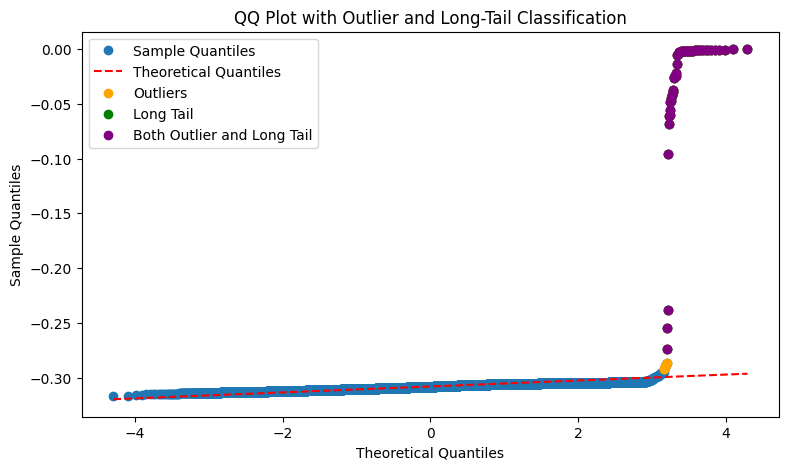

Outliers: 62
Long Tail: 54


In [34]:
outliers, long_tail = classify_qq_outliers(before_df[31][2:])

print(f"Outliers: {np.sum(outliers)}")
print(f"Long Tail: {np.sum(long_tail)}")

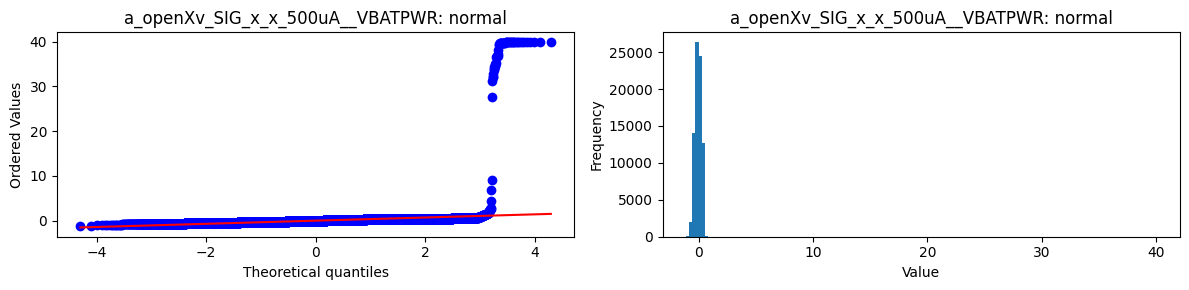

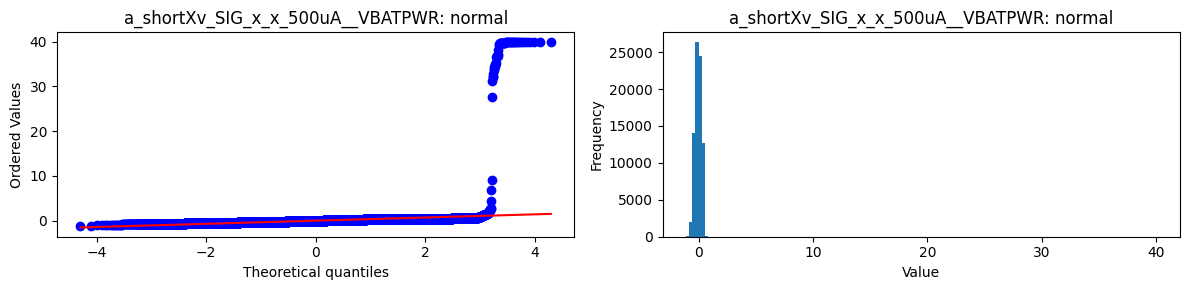

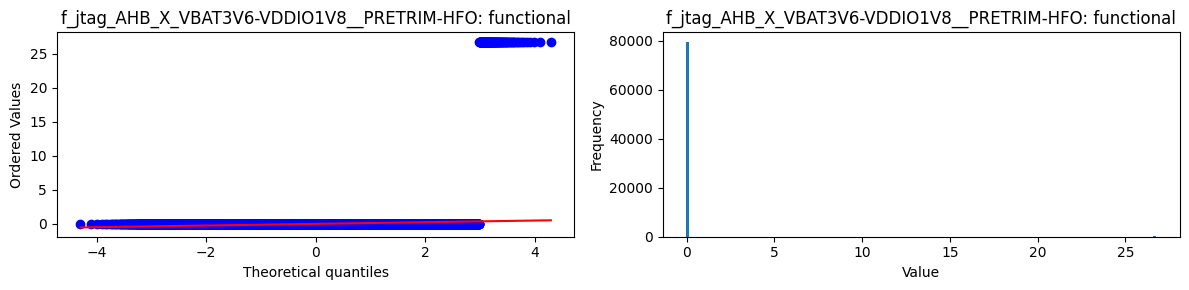

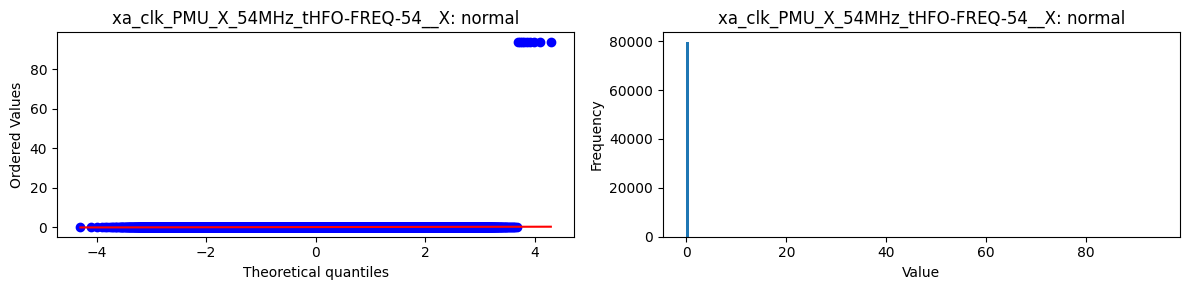

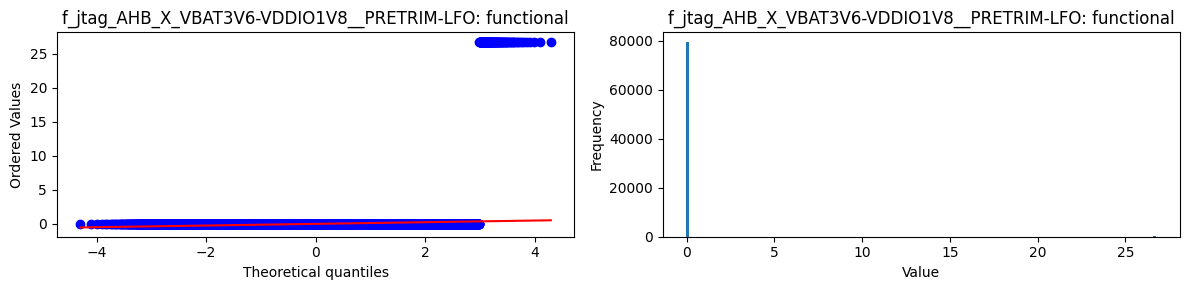

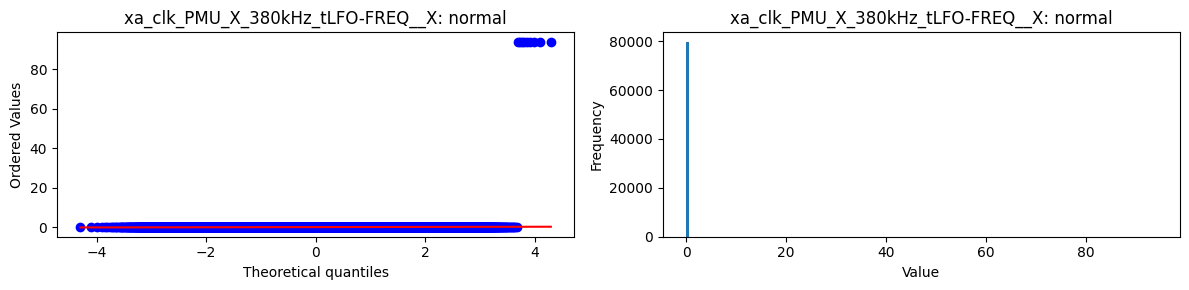

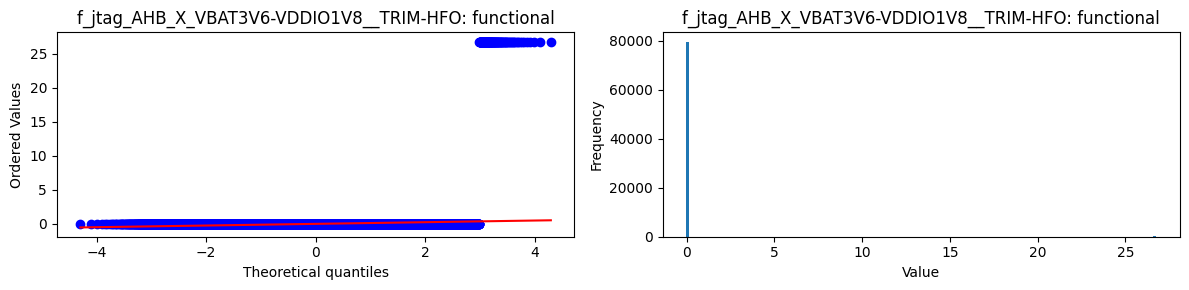

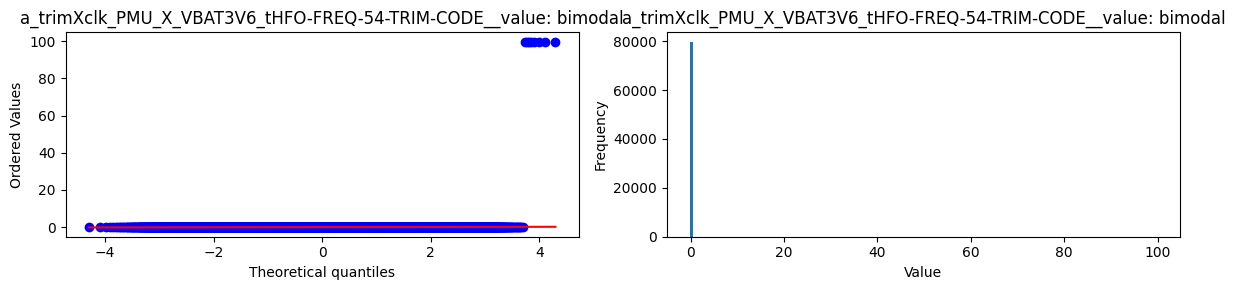

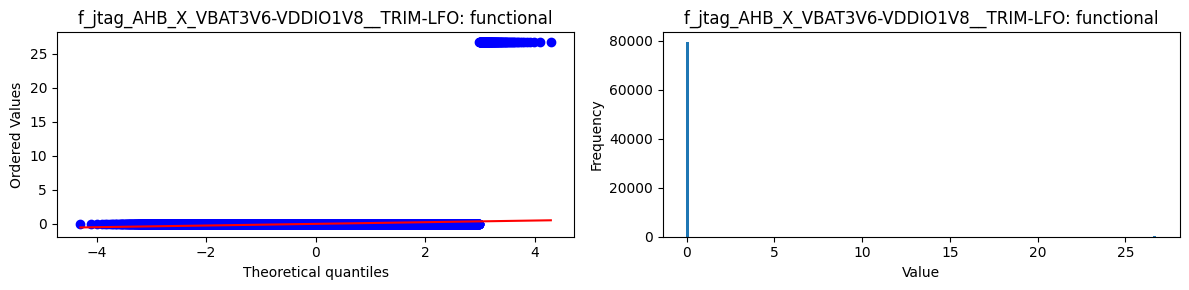

In [35]:
import scipy.stats as stats
import matplotlib.pyplot as plt

for col in before_df:
    test_name = before_df[col]['Name']
    label = before_df[col]['Distribution Type']
    before = before_df[col].dropna()
    before = pd.to_numeric(before, errors='coerce')

    # fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))
    # stats.probplot(before, dist="norm", plot=axes[0])
    # axes[0].set_title(f'{test_name}: {label}')
    # axes[1].hist(before, bins=150)
    # axes[1].set_xlabel('Value')
    # axes[1].set_ylabel('Frequency')
    # axes[1].set_title(f'{test_name}: {label}')
    # plt.tight_layout() 
    # plt.show()
    
    after = after_df[col].dropna()
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    stats.probplot(after, dist="norm", plot=axes[0])
    axes[0].set_title(f'{test_name}: {label}')
    axes[1].hist(after, bins=150)
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{test_name}: {label}')
    plt.tight_layout() 
    plt.show()

In [36]:
binary_distribution_counts = df_final_ty['Target'].value_counts()
binary_distribution_counts

Target
Other               1239
Outlier/Longtail     163
Name: count, dtype: int64

# Checking for null statistical features

In [37]:
# filter rows where any column has null values
null_df = df_final_ty[df_final_ty.isnull().any(axis=1)]

# check the target label (distribution) of these null rows
null_df['Target'].value_counts()

null_df.isnull().sum()

Name                    0
Target                  0
Target_Encoded          0
Distribution Type       0
Count                   0
Unique_Count            0
Mean                    0
Median                  0
Std_Dev                 0
IQR                     0
Skewness                0
Kurtosis                0
Min                     0
Max                     0
Range                   0
Upper_Tail              0
Lower_Tail              0
Extreme_Tail_95         0
Extreme_Tail_99         0
Extreme_Tail_05         0
Extreme_Tail_01         0
Upper_Tail_Mean         0
Upper_Tail_Var          0
Lower_Tail_Mean         0
Tail_Weight_Ratio       0
Tail_Length_Ratio_95    0
Tail_Length_Ratio_05    0
Excess_Kurtosis         0
P99                     0
P1                      0
Outliers_Zscore         0
Outliers_Zscore_prop    0
Outliers_IQR            0
Outliers_IQR_prop       0
Outliers_Tukey          0
Outliers_Tukey_prop     0
QQ Count                0
KS_Stat_norm            0
KS_P_value_n

# Dropping rows with any null values

In [38]:
# drop those rows (tests) with any null values for more consistency and since all are of the negative class 
df_final_ty_nonull = df_final_ty.dropna()
df_final_ty_nonull

,Name,Target,Target_Encoded,Distribution Type,Count,Unique_Count,Mean,Median,Std_Dev,IQR,Skewness,Kurtosis,Min,Max,Range,Upper_Tail,Lower_Tail,Extreme_Tail_95,Extreme_Tail_99,Extreme_Tail_05,Extreme_Tail_01,Upper_Tail_Mean,Upper_Tail_Var,Lower_Tail_Mean,Tail_Weight_Ratio,Tail_Length_Ratio_95,Tail_Length_Ratio_05,Excess_Kurtosis,P99,P1,Outliers_Zscore,Outliers_Zscore_prop,Outliers_IQR,Outliers_IQR_prop,Outliers_Tukey,Outliers_Tukey_prop,QQ Count,KS_Stat_norm,KS_P_value_norm,Shapiro_Stat,Shapiro_P_value
0,temperature,Other,0,functional,79783,1,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000,0.000000,0.000000,0,0.000000,0,0.0,0,0.000000,0,1.000000,0.000000e+00,0.000000,0.000000e+00
1,Device_Test_Time,Other,0,bimodal,79783,685,8.692199e-16,-0.384006,1.000006,0.495033,2.765450e+00,19.370179,-1.536323,10.604948,12.141271,0.147351,0.439845,8.779795,8.632444,0.575607,0.135761,2.268136,2.353370,0.029436,0.254540,17.735786,1.162765,16.370179,1.972504,-1.400562,128,0.001604,79783,1.0,13379,0.167692,256,0.288517,0.000000e+00,0.716606,5.274157e-137
2,Part_Id,Other,0,bimodal,79783,5699,8.549704e-17,0.000065,1.000006,1.732420,5.386640e-08,-1.200000,-1.731747,1.731877,3.463624,0.138594,0.138156,0.173242,0.034648,0.172695,0.034539,1.645191,0.002516,0.002502,0.000000,0.100000,0.099684,-4.200000,1.697229,-1.697208,0,0.000000,0,0.0,0,0.000000,1380,0.057294,4.318635e-228,0.954930,4.079635e-87
3,a_openXv_SIG_x_x_500uA__NFC_GPIO0,Outlier/Longtail,1,outlier,79783,35376,-1.807265e-14,0.002162,1.000006,0.867089,-2.258166e+01,2952.347830,-80.369501,39.794400,120.163901,0.199185,0.282360,38.919599,38.720413,79.424337,79.141978,1.192911,5.177754,7.841761,0.006919,44.885369,91.598855,2949.347830,1.073987,-1.227523,57,0.000714,0,0.0,57,0.000714,106,0.142341,0.000000e+00,0.379675,9.769087e-162
4,a_shortXv_SIG_x_x_500uA__NFC_GPIO0,Outlier/Longtail,1,outlier,79783,35376,-1.807265e-14,0.002162,1.000006,0.867089,-2.258166e+01,2952.347830,-80.369501,39.794400,120.163901,0.199185,0.282360,38.919599,38.720413,79.424337,79.141978,1.192911,5.177754,7.841761,0.006919,44.885369,91.598855,2949.347830,1.073987,-1.227523,57,0.000714,0,0.0,57,0.000714,106,0.142341,0.000000e+00,0.379675,9.769087e-162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397,f_nvm_programXxXPgmPatrepairinfo2M1YvhsYvhsYyY...,Other,0,functional,1284,2,1.660147e-16,-0.162416,1.000390,0.000000,0.000000e+00,0.000000,-0.162416,6.157036,6.319452,6.319452,0.000000,6.319452,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025701,0.000000,0.000000,-3.000000,6.157036,-0.162416,33,0.025701,1284,1.0,33,0.025701,66,1.000000,0.000000e+00,0.000000,0.000000e+00
1398,f_nvm_readifrXxXVfyPatrepairinfo2M1YvhsYvhsYyY...,Other,0,functional,1284,2,1.660147e-16,-0.162416,1.000390,0.000000,0.000000e+00,0.000000,-0.162416,6.157036,6.319452,6.319452,0.000000,6.319452,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025701,0.000000,0.000000,-3.000000,6.157036,-0.162416,33,0.025701,1284,1.0,33,0.025701,66,1.000000,0.000000e+00,0.000000,0.000000e+00
1399,f_nvm_XxXRdoutPatrepairinfo3M1YvhsYvhsYyYYy_1....,Other,0,functional,3098,1,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000,0.000000,0.000000,0,0.000000,0,0.0,0,0.000000,0,1.000000,0.000000e+00,0.000000,0.000000e+00
1400,f_nvm_readifrXxXVfyPatrepairinfo3M1YvhsYvhsYyY...,Other,0,functional,3098,2,-2.293553e-18,0.839089,1.000161,2.030858,0.000000e+00,0.000000,-1.191769,0.839089,2.030858,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000,0.839089,-1.191769,0,0.000000,0,0

# Saving processed data files
one dataset with null values (full), one set without null values

In [39]:
import pickle

data = {'ty_full': df_final_ty, 'ty_dropped': df_final_ty_nonull}

with open('ty_dataframes.pkl', 'wb') as file:
    pickle.dump(data, file)